# Kaggle Digit Recognizer
## Convolution Neural Network Model


In this notebook, We are going to implement CNN architecture.



### Step1
Follwing cell is to Import all relevant library also declare macros which we are going to use in this notebook

In [33]:
import tensorflow as tf
from random import randint
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from numpy import prod
import pre_processing 

# Network Parameters
IMAGE_SIZE = 28
# All the pixels in the image (28 * 28 = 784)
features_count = 784 # MNIST data input (img shape: 28*28)
# All the labels
labels_count = 10 # MNIST total classes (0-9 digits)

# Change if have a memory restrictions
batch_size = 4096

# TODO: Find the best parameters for each configuration
epochs = 10
keep_probability = 1

# Model save path
save_model_path = './cnn_digit_recognition'
#data = np.zeros(shape=(10000,28*28))

print ('Successfully Import of library ')

Successfully Import of library 


### step 2
get the data for network model
Data's are, train feature & label, cross-validation fetures & labels, and test feature and labels.
All labels are encoded.
All features are rescaled between -0.5 to 0.5 from 0 - 255


In [23]:
def get_data():
    return pre_processing.get_processed_data()

### Step :
Test the random image to verify how good the model is

In [24]:
def test_random_image(data):
    # test ramdom image
    loaded_graph = tf.Graph()
    top_n_predictions = 3

    with tf.Session(graph=loaded_graph) as session:
    # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(session, save_model_path)
        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('features:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_probability:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    #    loaded_GDoptimizer = loaded_graph.get_tensor_by_name('GDoptimizer:0')      

        num = randint(0, data.shape[0])
        print ('num:', num)
        img = data[num]
        img = img.reshape(IMAGE_SIZE, IMAGE_SIZE,1)
        classification = session.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions), feed_dict={loaded_x: [img], loaded_keep_prob: 1.0})
        plt.imshow(img.reshape(28, 28), cmap=plt.cm.binary)
        plt.show()
        print ('Top {} prediction :' .format(top_n_predictions))
        print ('{}% ' .format(classification[0]*100) )
        print ('predicted value {}' .format(classification[1]))
 

## Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we will implement the function conv2d_maxpool to apply convolution then max pooling:
Create the weight and bias using conv_ksize, conv_num_outputs and the shape of x_tensor.
Apply a convolution to x_tensor using weight and conv_strides.
We use same padding, but welcome to use any padding.
Add bias
Add a nonlinear activation to the convolution.
Apply Max Pooling using pool_ksize and pool_strides.
We use same padding, but you're welcome to use any padding.


In [25]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    dimension = x_tensor.get_shape().as_list()
    shape = list(conv_ksize + (dimension[-1],) + (conv_num_outputs,))
    #print(shape)
    filter_weights = tf.Variable(tf.truncated_normal(shape,0,0.1)) # (height, width, input_depth, output_depth)
    filter_bias = tf.Variable(tf.zeros(conv_num_outputs))
    padding = 'SAME'
    #print(list((1,)+conv_strides+(1,)))
    #print(filter_weights)
    conv_layer = tf.nn.conv2d(x_tensor, filter_weights, list((1,)+conv_strides+(1,)), padding)
    conv_layer = tf.nn.bias_add(conv_layer, filter_bias)
    
    conv_layer = tf.nn.relu(conv_layer)
    
    conv_layer = tf.nn.max_pool(
        conv_layer,
        ksize=[1] + list(pool_ksize) + [1],
        strides=[1] + list(pool_strides) + [1],
        padding='SAME')
    
    return conv_layer


### Flatten Layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). 


In [26]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    #return None
    dimension = x_tensor.get_shape().as_list()  
    display(dimension)
    x =  tf.reshape(x_tensor,[-1,prod(dimension[1:])])
    display(x.get_shape().as_list())
    return x


### Fully-Connected Layer
Implement the fully_conn function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs).  

In [27]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    dimension = x_tensor.get_shape().as_list()
    shape = list( (dimension[-1],) + (num_outputs,))
    print(x_tensor.get_shape())
    weight = tf.Variable(tf.truncated_normal(shape,0,0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    print (weight.get_shape(), bias.get_shape())
    return tf.nn.relu(tf.add(tf.matmul(x_tensor,weight), bias))
 

### Output Layer
Implement the output function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs). 
Note: Activation, softmax, or cross entropy should not be applied to this.


In [28]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    dimension = x_tensor.get_shape().as_list()
    shape = list( (dimension[-1],) + (num_outputs,))
    print(shape)
    weight = tf.Variable(tf.truncated_normal(shape,0,0.01))
    bias = tf.Variable(tf.zeros(num_outputs))

    return tf.add(tf.matmul(x_tensor,weight), bias)


### Create Convolutional Model
Implement the function conv_net to create a convolutional neural network model. The function takes in a batch of images, x, and outputs logits. Use the layers you created above to create this model:
Apply 1, 2, or 3 Convolution and Max Pool layers
Apply a Flatten Layer
Apply 1, 2, or 3 Fully Connected Layers
Apply an Output Layer
Return the output
Apply TensorFlow's Dropout to one or more layers in the model using keep_prob.


In [29]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    model = conv2d_maxpool(x, conv_num_outputs=18, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(8,8), pool_strides=(1,1))
    #model = conv2d_maxpool(x, conv_num_outputs=36, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    #model = conv2d_maxpool(model, conv_num_outputs=8, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(4,4), pool_strides=(1,1))
    #model = tf.nn.relu(model)
    model = tf.nn.dropout(model, keep_prob)    

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    model = flatten(model)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    model = fully_conn(model,200)
    #model = fully_conn(model,200)
    #model = fully_conn(model,20)
    #model = tf.nn.relu(model)
    
    model = tf.nn.dropout(model, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    model = output(model,10)
    
    # TODO: return output
    return model



def cnn_model():
##############################
## Build the Neural Network ##
##############################

    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Inputs
    image_shape = (IMAGE_SIZE,IMAGE_SIZE,1)
    features = tf.placeholder(tf.float32, [None] + list(image_shape), name="features")
    labels = tf.placeholder(tf.float32, (None, labels_count), name="label")
    keep_prob = tf.placeholder(tf.float32, name="keep_probability")

    # Model
    logits = conv_net(features, keep_prob)

    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(logits, name='logits')

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    return features, labels, keep_prob, logits, cost, accuracy, optimizer


### Train the Neural Network
Single Optimization
Implement the function train_neural_network to do a single optimization. The optimization should use optimizer to optimize in session with a feed_dict of the following:
x for image input
y for labels
keep_prob for keep probability for dropout
This function will be called for each batch, so tf.global_variables_initializer() has already been called.
Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [30]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, features, lables, keep_prob):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    #features, labels, keep_prob, logits, cost, accuracy, optimizer = cnn_model()
    session.run(optimizer, feed_dict={features:feature_batch, labels:label_batch, keep_prob:keep_probability})


### Show Stats
Implement the function print_stats to print loss and validation accuracy. Use the global variables valid_features and valid_labels to calculate validation accuracy. Use a keep probability of 1.0 to calculate the loss and validation accuracy.


In [31]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, features, labels, keep_prob):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    #features, labels, keep_prob, logits, cost, accuracy, optimizer = cnn_model()
    loss = session.run(cost, feed_dict={features:feature_batch, labels:label_batch, keep_prob:1.0})
    valid_acc = session.run(accuracy, feed_dict={
                features: valid_features,
                labels: valid_labels,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))

### Hyperparameters
Tune the following parameters:
Set epochs to the number of iterations until the network stops learning or start overfitting
Set batch_size to the highest number that your machine has memory for. Most people set them to common sizes of memory:
64
128
256
...
Set keep_probability to the probability of keeping a node using dropout

In [32]:
# TODO: Tune Parameters
#epochs = 100
#batch_size = 512
keep_probability = 1

### Train on a Single Batch
Instead of training the neural network on all the batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [38]:
print('Checking the Training on a Single Batch...')
features, labels, keep_prob, logits, cost, accuracy, optimizer = cnn_model()
train_features, valid_features, train_labels, valid_labels, test_data, test_label = get_data()
# The accuracy measured against the validation set
validation_accuracy = 0.0

#train_features = train_features.reshape(57000, IMAGE_SIZE, IMAGE_SIZE, 1)
#valid_features = valid_features.reshape(3000, IMAGE_SIZE, IMAGE_SIZE, 1)
train_feed_dict = {features: train_features, labels: train_labels, keep_prob:keep_probability}
valid_feed_dict = {features: valid_features, labels: valid_labels, keep_prob:keep_probability}

 
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    batch_count = int(math.ceil(len(train_features)/batch_size))
    # Training cycle
    for epoch_i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        # display((batch_count))
        # The training cycle
        for batch_i in batches_pbar:
                # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            train_neural_network(sess, optimizer, keep_probability, 
                                 batch_features, batch_labels,
                                 features, labels, keep_prob)
            #validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
            print_stats(sess, batch_features, batch_labels, cost, accuracy, 
                        features, labels, keep_prob)
        
            print('Epoch {:>2}, Batch {}:  '.format(epoch_i + 1, batch_i), end='')
            #print('Validation accuracy at {}'.format(validation_accuracy))
        

Checking the Training on a Single Batch...


[None, 28, 28, 18]

[None, 14112]

(?, 14112)
(14112, 20) (20,)
[20, 10]
data processing
get_data
downloading train-images-idx3-ubyte.gz
downloading train-labels-idx1-ubyte.gz
downloading t10k-images-idx3-ubyte.gz
downloading t10k-labels-idx1-ubyte.gz
Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz
All features and labels uncompressed.
Training features and labels randomized and split.



Epoch  1/1:   0%|                                  | 0/28 [00:00<?, ?batches/s]

Loss:     2.2980 Validation Accuracy: 0.107000
Epoch  1, Batch 0:  


Epoch  1/1:   4%|▉                         | 1/28 [00:12<05:25, 12.07s/batches]

Loss:     2.2939 Validation Accuracy: 0.152333
Epoch  1, Batch 1:  


Epoch  1/1:   7%|█▊                        | 2/28 [00:23<05:09, 11.92s/batches]

Loss:     2.2897 Validation Accuracy: 0.297667
Epoch  1, Batch 2:  


Epoch  1/1:  11%|██▊                       | 3/28 [00:35<04:56, 11.86s/batches]

Loss:     2.2828 Validation Accuracy: 0.295000
Epoch  1, Batch 3:  


Epoch  1/1:  14%|███▋                      | 4/28 [00:47<04:45, 11.88s/batches]

Loss:     2.2727 Validation Accuracy: 0.287667
Epoch  1, Batch 4:  


Epoch  1/1:  18%|████▋                     | 5/28 [00:59<04:32, 11.84s/batches]

Loss:     2.2665 Validation Accuracy: 0.300000
Epoch  1, Batch 5:  


Epoch  1/1:  21%|█████▌                    | 6/28 [01:11<04:20, 11.86s/batches]

Loss:     2.2559 Validation Accuracy: 0.321667
Epoch  1, Batch 6:  


Epoch  1/1:  25%|██████▌                   | 7/28 [01:22<04:08, 11.84s/batches]

Loss:     2.2390 Validation Accuracy: 0.326667
Epoch  1, Batch 7:  


Epoch  1/1:  29%|███████▍                  | 8/28 [01:34<03:57, 11.85s/batches]

Loss:     2.2292 Validation Accuracy: 0.349667
Epoch  1, Batch 8:  


Epoch  1/1:  32%|████████▎                 | 9/28 [01:46<03:45, 11.88s/batches]

Loss:     2.2033 Validation Accuracy: 0.385667
Epoch  1, Batch 9:  


Epoch  1/1:  36%|████████▉                | 10/28 [01:58<03:33, 11.88s/batches]

Loss:     2.1771 Validation Accuracy: 0.372333
Epoch  1, Batch 10:  


Epoch  1/1:  39%|█████████▊               | 11/28 [02:10<03:22, 11.91s/batches]

Loss:     2.1516 Validation Accuracy: 0.363000
Epoch  1, Batch 11:  


Epoch  1/1:  43%|██████████▋              | 12/28 [02:23<03:11, 11.95s/batches]

Loss:     2.1287 Validation Accuracy: 0.356000
Epoch  1, Batch 12:  


Epoch  1/1:  46%|███████████▌             | 13/28 [02:35<02:59, 12.00s/batches]

Loss:     2.0891 Validation Accuracy: 0.350000
Epoch  1, Batch 13:  


Epoch  1/1:  50%|████████████▌            | 14/28 [02:48<02:48, 12.05s/batches]

Loss:     2.0626 Validation Accuracy: 0.370333
Epoch  1, Batch 14:  


Epoch  1/1:  54%|█████████████▍           | 15/28 [03:00<02:36, 12.05s/batches]

Loss:     2.0314 Validation Accuracy: 0.408000
Epoch  1, Batch 15:  


Epoch  1/1:  57%|██████████████▎          | 16/28 [03:13<02:24, 12.08s/batches]

Loss:     1.9983 Validation Accuracy: 0.442333
Epoch  1, Batch 16:  


Epoch  1/1:  61%|███████████████▏         | 17/28 [03:26<02:13, 12.15s/batches]

Loss:     1.9688 Validation Accuracy: 0.478667
Epoch  1, Batch 17:  


Epoch  1/1:  64%|████████████████         | 18/28 [03:39<02:01, 12.19s/batches]

Loss:     1.9524 Validation Accuracy: 0.505333
Epoch  1, Batch 18:  


Epoch  1/1:  68%|████████████████▉        | 19/28 [03:53<01:50, 12.27s/batches]

Loss:     1.9152 Validation Accuracy: 0.523333
Epoch  1, Batch 19:  


Epoch  1/1:  71%|█████████████████▊       | 20/28 [04:05<01:38, 12.28s/batches]

Loss:     1.8930 Validation Accuracy: 0.537333
Epoch  1, Batch 20:  


Epoch  1/1:  75%|██████████████████▊      | 21/28 [04:17<01:25, 12.25s/batches]

Loss:     1.8694 Validation Accuracy: 0.558333
Epoch  1, Batch 21:  


Epoch  1/1:  79%|███████████████████▋     | 22/28 [04:30<01:13, 12.29s/batches]

Loss:     1.8202 Validation Accuracy: 0.569000
Epoch  1, Batch 22:  


Epoch  1/1:  82%|████████████████████▌    | 23/28 [04:42<01:01, 12.29s/batches]

Loss:     1.8154 Validation Accuracy: 0.573000
Epoch  1, Batch 23:  


Epoch  1/1:  86%|█████████████████████▍   | 24/28 [04:55<00:49, 12.31s/batches]

Loss:     1.7712 Validation Accuracy: 0.580333
Epoch  1, Batch 24:  


Epoch  1/1:  89%|██████████████████████▎  | 25/28 [05:07<00:36, 12.29s/batches]

Loss:     1.7308 Validation Accuracy: 0.592333
Epoch  1, Batch 25:  


Epoch  1/1:  93%|███████████████████████▏ | 26/28 [05:19<00:24, 12.30s/batches]

Loss:     1.6896 Validation Accuracy: 0.604333
Epoch  1, Batch 26:  


Epoch  1/1:  96%|████████████████████████ | 27/28 [05:32<00:12, 12.30s/batches]

Loss:     1.6664 Validation Accuracy: 0.620000
Epoch  1, Batch 27:  


Epoch  1/1: 100%|█████████████████████████| 28/28 [05:42<00:00, 12.24s/batches]


### Fully Train the Model
Now that you got a good accuracy with a single batch, try it with all batches.

In [34]:
def train_model():
#train_features, train_labels, valid_features, valid_labels, test_data, test_label):
    
    print('Training...')
        # Feed dicts for training, validation, and test session
    validation_accuracy = 0.0
    log_batch_step = 10
    batches = []
    loss_batch = []
    train_acc_batch = []
    valid_acc_batch = []
    
    features, labels, keep_prob, logits, cost, accuracy, optimizer = cnn_model()

    train_feed_dict = {features: train_features, labels: train_labels, keep_prob:keep_probability}
    valid_feed_dict = {features: valid_features, labels: valid_labels, keep_prob:keep_probability}
 
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        batch_count = int(math.ceil(len(train_features)/batch_size))
        # Training cycle
        for epoch_i in range(epochs):
            avg_cost = 0
            # Progress bar
            batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            # display((batch_count))
            # The training cycle
            for batch_i in batches_pbar:
                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = train_features[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                # Run optimizer and get loss
                _, l = sess.run(
                        [optimizer, cost],
                        feed_dict={features: batch_features, labels: batch_labels, keep_prob: keep_probability})
                print_stats(sess, batch_features, batch_labels, 
                            cost, accuracy, features, labels, keep_prob)
                  
                avg_cost += l / batch_size
                        
                # Log every 50 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
                    validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)
                #train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                #print('Epoch {:>2}, Batch {}:  '.format(epoch_i + 1, batch_i), end='')
                #print_stats(sess, batch_features, batch_labels, cost, accuracy, valid_features, valid_labels)
               # print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
               #                                                     l,
               #                                                     validation_accuracy))   
            print ("Epoch:", (epoch_i+1), "cost =", "{:.5f}".format(avg_cost))
            # Check accuracy against Validation data
            validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
            print('Validation accuracy at {}'.format(validation_accuracy))

        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)

    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

    print('Validation accuracy at {}'.format(validation_accuracy))
    
#train_features, valid_features, train_labels, valid_labels, test_data, test_label = get_data()
#train_model(train_features, train_labels, valid_features, valid_labels, test_data, test_label)


### Checkpoint
The model has been saved to disk.
Test Model
Test your model against the test dataset. This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

In [40]:
def test_model():
    """
    Test the saved model against the test dataset
    """
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('features:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_probability:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_accuracy = sess.run(loaded_acc, feed_dict={loaded_x: test_data, loaded_y: test_label, loaded_keep_prob: 1.0})
        
        print('Test Accuracy is {}'.format(test_accuracy))

       

data processing
get_data
downloading train-images-idx3-ubyte.gz
downloading train-labels-idx1-ubyte.gz
downloading t10k-images-idx3-ubyte.gz
downloading t10k-labels-idx1-ubyte.gz
Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz
All features and labels uncompressed.
Training features and labels randomized and split.
Training...


[None, 28, 28, 18]

[None, 14112]

(?, 14112)
(14112, 200) (200,)
[200, 10]


Epoch  1/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     2.2399 Validation Accuracy: 0.163333


Epoch  1/10:   7%|█▋                      | 1/14 [01:59<25:55, 119.65s/batches]

Loss:     2.1355 Validation Accuracy: 0.371333


Epoch  1/10:  14%|███▌                     | 2/14 [02:26<14:36, 73.03s/batches]

Loss:     2.0424 Validation Accuracy: 0.423000


Epoch  1/10:  21%|█████▎                   | 3/14 [02:50<10:26, 56.94s/batches]

Loss:     1.9369 Validation Accuracy: 0.530333


Epoch  1/10:  29%|███████▏                 | 4/14 [03:16<08:10, 49.09s/batches]

Loss:     1.8355 Validation Accuracy: 0.705667


Epoch  1/10:  36%|████████▉                | 5/14 [03:42<06:40, 44.46s/batches]

Loss:     1.7119 Validation Accuracy: 0.718667


Epoch  1/10:  43%|██████████▋              | 6/14 [04:07<05:29, 41.23s/batches]

Loss:     1.5914 Validation Accuracy: 0.745667


Epoch  1/10:  50%|████████████▌            | 7/14 [04:33<04:33, 39.05s/batches]

Loss:     1.4750 Validation Accuracy: 0.689000


Epoch  1/10:  57%|██████████████▎          | 8/14 [04:58<03:43, 37.29s/batches]

Loss:     1.3612 Validation Accuracy: 0.726333


Epoch  1/10:  64%|████████████████         | 9/14 [05:24<03:00, 36.10s/batches]

Loss:     1.2488 Validation Accuracy: 0.774000


Epoch  1/10:  71%|█████████████████▏      | 10/14 [05:50<02:20, 35.01s/batches]

Loss:     1.1438 Validation Accuracy: 0.788333


Epoch  1/10:  79%|██████████████████▊     | 11/14 [07:44<02:06, 42.22s/batches]

Loss:     1.0323 Validation Accuracy: 0.791667


Epoch  1/10:  86%|████████████████████▌   | 12/14 [08:11<01:21, 40.96s/batches]

Loss:     0.9381 Validation Accuracy: 0.792667


Epoch  1/10:  93%|██████████████████████▎ | 13/14 [08:37<00:39, 39.82s/batches]

Loss:     0.8550 Validation Accuracy: 0.801667


Epoch  1/10: 100%|████████████████████████| 14/14 [09:01<00:00, 38.70s/batches]


Epoch: 1 cost = 0.00563
Validation accuracy at 0.8016666769981384


Epoch  2/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.7747 Validation Accuracy: 0.804333


Epoch  2/10:   7%|█▋                      | 1/14 [01:49<23:40, 109.30s/batches]

Loss:     0.7302 Validation Accuracy: 0.817000


Epoch  2/10:  14%|███▌                     | 2/14 [02:15<13:31, 67.61s/batches]

Loss:     0.6877 Validation Accuracy: 0.820667


Epoch  2/10:  21%|█████▎                   | 3/14 [02:41<09:53, 53.96s/batches]

Loss:     0.6128 Validation Accuracy: 0.834000


Epoch  2/10:  29%|███████▏                 | 4/14 [03:08<07:51, 47.14s/batches]

Loss:     0.5886 Validation Accuracy: 0.844667


Epoch  2/10:  36%|████████▉                | 5/14 [03:35<06:28, 43.18s/batches]

Loss:     0.5367 Validation Accuracy: 0.846667


Epoch  2/10:  43%|██████████▋              | 6/14 [04:02<05:23, 40.42s/batches]

Loss:     0.4970 Validation Accuracy: 0.856667


Epoch  2/10:  50%|████████████▌            | 7/14 [04:29<04:29, 38.55s/batches]

Loss:     0.4791 Validation Accuracy: 0.865333


Epoch  2/10:  57%|██████████████▎          | 8/14 [04:56<03:42, 37.08s/batches]

Loss:     0.4376 Validation Accuracy: 0.872667


Epoch  2/10:  64%|████████████████         | 9/14 [05:22<02:59, 35.84s/batches]

Loss:     0.4350 Validation Accuracy: 0.882000


Epoch  2/10:  71%|█████████████████▏      | 10/14 [05:49<02:19, 34.91s/batches]

Loss:     0.4064 Validation Accuracy: 0.889333


Epoch  2/10:  79%|██████████████████▊     | 11/14 [07:44<02:06, 42.20s/batches]

Loss:     0.3937 Validation Accuracy: 0.895000


Epoch  2/10:  86%|████████████████████▌   | 12/14 [08:11<01:21, 40.93s/batches]

Loss:     0.3478 Validation Accuracy: 0.900667


Epoch  2/10:  93%|██████████████████████▎ | 13/14 [08:37<00:39, 39.82s/batches]

Loss:     0.3325 Validation Accuracy: 0.904667


Epoch  2/10: 100%|████████████████████████| 14/14 [09:03<00:00, 38.82s/batches]


Epoch: 2 cost = 0.00191
Validation accuracy at 0.9046666622161865


Epoch  3/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.3175 Validation Accuracy: 0.909333


Epoch  3/10:   7%|█▋                      | 1/14 [01:50<24:00, 110.77s/batches]

Loss:     0.3034 Validation Accuracy: 0.917333


Epoch  3/10:  14%|███▌                     | 2/14 [02:18<13:48, 69.02s/batches]

Loss:     0.3358 Validation Accuracy: 0.917000


Epoch  3/10:  21%|█████▎                   | 3/14 [02:44<10:04, 54.99s/batches]

Loss:     0.2894 Validation Accuracy: 0.921333


Epoch  3/10:  29%|███████▏                 | 4/14 [03:11<07:58, 47.86s/batches]

Loss:     0.2839 Validation Accuracy: 0.920667


Epoch  3/10:  36%|████████▉                | 5/14 [03:37<06:31, 43.51s/batches]

Loss:     0.2739 Validation Accuracy: 0.927333


Epoch  3/10:  43%|██████████▋              | 6/14 [04:03<05:24, 40.54s/batches]

Loss:     0.2551 Validation Accuracy: 0.930000


Epoch  3/10:  50%|████████████▌            | 7/14 [04:29<04:29, 38.55s/batches]

Loss:     0.2607 Validation Accuracy: 0.926333


Epoch  3/10:  57%|██████████████▎          | 8/14 [04:55<03:41, 36.98s/batches]

Loss:     0.2217 Validation Accuracy: 0.930667


Epoch  3/10:  64%|████████████████         | 9/14 [05:22<02:59, 35.86s/batches]

Loss:     0.2386 Validation Accuracy: 0.937000


Epoch  3/10:  71%|█████████████████▏      | 10/14 [05:49<02:19, 34.92s/batches]

Loss:     0.2325 Validation Accuracy: 0.934667


Epoch  3/10:  79%|██████████████████▊     | 11/14 [07:42<02:06, 42.04s/batches]

Loss:     0.2328 Validation Accuracy: 0.937000


Epoch  3/10:  86%|████████████████████▌   | 12/14 [08:09<01:21, 40.76s/batches]

Loss:     0.2089 Validation Accuracy: 0.934333


Epoch  3/10:  93%|██████████████████████▎ | 13/14 [08:34<00:39, 39.59s/batches]

Loss:     0.2019 Validation Accuracy: 0.938333


Epoch  3/10: 100%|████████████████████████| 14/14 [08:59<00:00, 38.54s/batches]


Epoch: 3 cost = 0.00094
Validation accuracy at 0.9383333325386047


Epoch  4/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.1910 Validation Accuracy: 0.949000


Epoch  4/10:   7%|█▋                      | 1/14 [01:50<24:00, 110.82s/batches]

Loss:     0.1871 Validation Accuracy: 0.946000


Epoch  4/10:  14%|███▌                     | 2/14 [02:16<13:36, 68.07s/batches]

Loss:     0.2276 Validation Accuracy: 0.948333


Epoch  4/10:  21%|█████▎                   | 3/14 [02:42<09:57, 54.33s/batches]

Loss:     0.1833 Validation Accuracy: 0.948333


Epoch  4/10:  29%|███████▏                 | 4/14 [03:08<07:51, 47.10s/batches]

Loss:     0.1834 Validation Accuracy: 0.949667


Epoch  4/10:  36%|████████▉                | 5/14 [03:34<06:26, 42.91s/batches]

Loss:     0.1836 Validation Accuracy: 0.950667


Epoch  4/10:  43%|██████████▋              | 6/14 [04:01<05:21, 40.17s/batches]

Loss:     0.1694 Validation Accuracy: 0.952333


Epoch  4/10:  50%|████████████▌            | 7/14 [04:27<04:27, 38.21s/batches]

Loss:     0.1689 Validation Accuracy: 0.953333


Epoch  4/10:  57%|██████████████▎          | 8/14 [04:53<03:40, 36.72s/batches]

Loss:     0.1440 Validation Accuracy: 0.954333


Epoch  4/10:  64%|████████████████         | 9/14 [05:19<02:57, 35.55s/batches]

Loss:     0.1614 Validation Accuracy: 0.957667


Epoch  4/10:  71%|█████████████████▏      | 10/14 [05:46<02:18, 34.62s/batches]

Loss:     0.1479 Validation Accuracy: 0.957667


Epoch  4/10:  79%|██████████████████▊     | 11/14 [07:33<02:03, 41.25s/batches]

Loss:     0.1606 Validation Accuracy: 0.958667


Epoch  4/10:  86%|████████████████████▌   | 12/14 [08:00<01:20, 40.00s/batches]

Loss:     0.1412 Validation Accuracy: 0.957000


Epoch  4/10:  93%|██████████████████████▎ | 13/14 [08:26<00:38, 38.99s/batches]

Loss:     0.1439 Validation Accuracy: 0.957000


Epoch  4/10: 100%|████████████████████████| 14/14 [08:51<00:00, 37.97s/batches]


Epoch: 4 cost = 0.00060
Validation accuracy at 0.9570000171661377


Epoch  5/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.1395 Validation Accuracy: 0.959333


Epoch  5/10:   7%|█▋                      | 1/14 [01:47<23:15, 107.38s/batches]

Loss:     0.1268 Validation Accuracy: 0.960333


Epoch  5/10:  14%|███▌                     | 2/14 [02:12<13:14, 66.23s/batches]

Loss:     0.1643 Validation Accuracy: 0.961667


Epoch  5/10:  21%|█████▎                   | 3/14 [02:38<09:41, 52.90s/batches]

Loss:     0.1402 Validation Accuracy: 0.961333


Epoch  5/10:  29%|███████▏                 | 4/14 [03:05<07:42, 46.28s/batches]

Loss:     0.1344 Validation Accuracy: 0.965667


Epoch  5/10:  36%|████████▉                | 5/14 [03:31<06:20, 42.31s/batches]

Loss:     0.1325 Validation Accuracy: 0.965000


Epoch  5/10:  43%|██████████▋              | 6/14 [03:57<05:17, 39.65s/batches]

Loss:     0.1287 Validation Accuracy: 0.964333


Epoch  5/10:  50%|████████████▌            | 7/14 [04:24<04:24, 37.74s/batches]

Loss:     0.1302 Validation Accuracy: 0.965667


Epoch  5/10:  57%|██████████████▎          | 8/14 [04:49<03:36, 36.13s/batches]

Loss:     0.1118 Validation Accuracy: 0.966333


Epoch  5/10:  64%|████████████████         | 9/14 [05:15<02:55, 35.01s/batches]

Loss:     0.1254 Validation Accuracy: 0.967667


Epoch  5/10:  71%|█████████████████▏      | 10/14 [05:41<02:16, 34.12s/batches]

Loss:     0.1096 Validation Accuracy: 0.967333


Epoch  5/10:  79%|██████████████████▊     | 11/14 [07:45<02:07, 42.33s/batches]

Loss:     0.1270 Validation Accuracy: 0.968667


Epoch  5/10:  86%|████████████████████▌   | 12/14 [08:25<01:24, 42.11s/batches]

Loss:     0.1108 Validation Accuracy: 0.968000


Epoch  5/10:  93%|██████████████████████▎ | 13/14 [12:20<00:56, 56.95s/batches]

Loss:     0.1147 Validation Accuracy: 0.970333


Epoch  5/10: 100%|████████████████████████| 14/14 [12:44<00:00, 54.60s/batches]


Epoch: 5 cost = 0.00045
Validation accuracy at 0.9703333377838135


Epoch  6/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.1121 Validation Accuracy: 0.970000


Epoch  6/10:   7%|█▋                      | 1/14 [01:55<25:01, 115.50s/batches]

Loss:     0.0996 Validation Accuracy: 0.970000


Epoch  6/10:  14%|███▌                     | 2/14 [02:23<14:20, 71.73s/batches]

Loss:     0.1329 Validation Accuracy: 0.971333


Epoch  6/10:  21%|█████▎                   | 3/14 [02:51<10:27, 57.01s/batches]

Loss:     0.1135 Validation Accuracy: 0.971333


Epoch  6/10:  29%|███████▏                 | 4/14 [03:18<08:16, 49.63s/batches]

Loss:     0.1100 Validation Accuracy: 0.970667


Epoch  6/10:  36%|████████▉                | 5/14 [03:45<06:46, 45.18s/batches]

Loss:     0.1073 Validation Accuracy: 0.972667


Epoch  6/10:  43%|██████████▋              | 6/14 [04:19<05:45, 43.23s/batches]

Loss:     0.1050 Validation Accuracy: 0.973000


Epoch  6/10:  50%|████████████▌            | 7/14 [04:53<04:53, 41.98s/batches]

Loss:     0.1068 Validation Accuracy: 0.974333


Epoch  6/10:  57%|██████████████▎          | 8/14 [05:27<04:05, 40.92s/batches]

Loss:     0.0919 Validation Accuracy: 0.974667


Epoch  6/10:  64%|████████████████         | 9/14 [06:01<03:20, 40.14s/batches]

Loss:     0.1046 Validation Accuracy: 0.973667


Epoch  6/10:  71%|█████████████████▏      | 10/14 [06:34<02:37, 39.40s/batches]

Loss:     0.0893 Validation Accuracy: 0.973667


Epoch  6/10:  79%|██████████████████▊     | 11/14 [09:04<02:28, 49.46s/batches]

Loss:     0.1062 Validation Accuracy: 0.976000


Epoch  6/10:  86%|████████████████████▌   | 12/14 [09:40<01:36, 48.38s/batches]

Loss:     0.0922 Validation Accuracy: 0.975333


Epoch  6/10:  93%|██████████████████████▎ | 13/14 [10:14<00:47, 47.24s/batches]

Loss:     0.0975 Validation Accuracy: 0.975667


Epoch  6/10: 100%|████████████████████████| 14/14 [10:43<00:00, 46.00s/batches]


Epoch: 6 cost = 0.00037
Validation accuracy at 0.9756666421890259


Epoch  7/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.0931 Validation Accuracy: 0.977000


Epoch  7/10:   7%|█▋                      | 1/14 [02:28<32:04, 148.03s/batches]

Loss:     0.0822 Validation Accuracy: 0.977000


Epoch  7/10:  14%|███▌                     | 2/14 [03:01<18:08, 90.74s/batches]

Loss:     0.1137 Validation Accuracy: 0.977000


Epoch  7/10:  21%|█████▎                   | 3/14 [03:35<13:10, 71.85s/batches]

Loss:     0.0976 Validation Accuracy: 0.976667


Epoch  7/10:  29%|███████▏                 | 4/14 [04:07<10:18, 61.86s/batches]

Loss:     0.0940 Validation Accuracy: 0.978333


Epoch  7/10:  36%|████████▉                | 5/14 [04:41<08:26, 56.26s/batches]

Loss:     0.0921 Validation Accuracy: 0.977000


Epoch  7/10:  43%|██████████▋              | 6/14 [05:08<06:51, 51.42s/batches]

Loss:     0.0920 Validation Accuracy: 0.977000


Epoch  7/10:  50%|████████████▌            | 7/14 [05:41<05:41, 48.73s/batches]

Loss:     0.0909 Validation Accuracy: 0.977333


Epoch  7/10:  57%|██████████████▎          | 8/14 [06:16<04:42, 47.11s/batches]

Loss:     0.0784 Validation Accuracy: 0.978333


Epoch  7/10:  64%|████████████████         | 9/14 [06:51<03:48, 45.75s/batches]

Loss:     0.0910 Validation Accuracy: 0.978000


Epoch  7/10:  71%|█████████████████▏      | 10/14 [07:26<02:58, 44.65s/batches]

Loss:     0.0764 Validation Accuracy: 0.978000


Epoch  7/10:  79%|██████████████████▊     | 11/14 [09:51<02:41, 53.80s/batches]

Loss:     0.0909 Validation Accuracy: 0.980333


Epoch  7/10:  86%|████████████████████▌   | 12/14 [10:25<01:44, 52.13s/batches]

Loss:     0.0790 Validation Accuracy: 0.980333


Epoch  7/10:  93%|██████████████████████▎ | 13/14 [10:58<00:50, 50.63s/batches]

Loss:     0.0856 Validation Accuracy: 0.979000


Epoch  7/10: 100%|████████████████████████| 14/14 [11:29<00:00, 49.25s/batches]


Epoch: 7 cost = 0.00031
Validation accuracy at 0.9789999723434448


Epoch  8/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.0803 Validation Accuracy: 0.978333


Epoch  8/10:   7%|█▋                      | 1/14 [02:20<30:23, 140.25s/batches]

Loss:     0.0700 Validation Accuracy: 0.980000


Epoch  8/10:  14%|███▌                     | 2/14 [02:53<17:23, 86.94s/batches]

Loss:     0.0996 Validation Accuracy: 0.979333


Epoch  8/10:  21%|█████▎                   | 3/14 [03:27<12:39, 69.06s/batches]

Loss:     0.0868 Validation Accuracy: 0.980333


Epoch  8/10:  29%|███████▏                 | 4/14 [04:01<10:04, 60.47s/batches]

Loss:     0.0838 Validation Accuracy: 0.980000


Epoch  8/10:  36%|████████▉                | 5/14 [04:35<08:15, 55.04s/batches]

Loss:     0.0798 Validation Accuracy: 0.980000


Epoch  8/10:  43%|██████████▋              | 6/14 [05:09<06:52, 51.55s/batches]

Loss:     0.0813 Validation Accuracy: 0.979667


Epoch  8/10:  50%|████████████▌            | 7/14 [05:43<05:43, 49.04s/batches]

Loss:     0.0807 Validation Accuracy: 0.979333


Epoch  8/10:  57%|██████████████▎          | 8/14 [06:18<04:43, 47.25s/batches]

Loss:     0.0689 Validation Accuracy: 0.980000


Epoch  8/10:  64%|████████████████         | 9/14 [06:50<03:48, 45.65s/batches]

Loss:     0.0803 Validation Accuracy: 0.979333


Epoch  8/10:  71%|█████████████████▏      | 10/14 [07:24<02:57, 44.42s/batches]

Loss:     0.0667 Validation Accuracy: 0.980667


Epoch  8/10:  79%|██████████████████▊     | 11/14 [09:50<02:40, 53.64s/batches]

Loss:     0.0810 Validation Accuracy: 0.981667


Epoch  8/10:  86%|████████████████████▌   | 12/14 [10:26<01:44, 52.18s/batches]

Loss:     0.0695 Validation Accuracy: 0.982333


Epoch  8/10:  93%|██████████████████████▎ | 13/14 [11:00<00:50, 50.79s/batches]

Loss:     0.0762 Validation Accuracy: 0.981333


Epoch  8/10: 100%|████████████████████████| 14/14 [11:33<00:00, 49.56s/batches]


Epoch: 8 cost = 0.00028
Validation accuracy at 0.981333315372467


Epoch  9/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.0716 Validation Accuracy: 0.981000


Epoch  9/10:   7%|█▌                    | 1/14 [12:58<2:48:35, 778.10s/batches]

Loss:     0.0617 Validation Accuracy: 0.981667


Epoch  9/10:  14%|███▏                  | 2/14 [13:43<1:22:23, 411.99s/batches]

Loss:     0.0889 Validation Accuracy: 0.980333


Epoch  9/10:  21%|█████▏                  | 3/14 [14:28<53:02, 289.35s/batches]

Loss:     0.0786 Validation Accuracy: 0.981000


Epoch  9/10:  29%|██████▊                 | 4/14 [15:12<38:00, 228.01s/batches]

Loss:     0.0762 Validation Accuracy: 0.983333


Epoch  9/10:  36%|████████▌               | 5/14 [15:54<28:37, 190.81s/batches]

Loss:     0.0716 Validation Accuracy: 0.982667


Epoch  9/10:  43%|██████████▎             | 6/14 [16:37<22:09, 166.21s/batches]

Loss:     0.0733 Validation Accuracy: 0.981667


Epoch  9/10:  50%|████████████            | 7/14 [17:19<17:19, 148.56s/batches]

Loss:     0.0732 Validation Accuracy: 0.981333


Epoch  9/10:  57%|█████████████▋          | 8/14 [18:00<13:30, 135.11s/batches]

Loss:     0.0618 Validation Accuracy: 0.982000


Epoch  9/10:  64%|███████████████▍        | 9/14 [18:43<10:24, 124.86s/batches]

Loss:     0.0722 Validation Accuracy: 0.982667


Epoch  9/10:  71%|████████████████▍      | 10/14 [19:27<07:46, 116.72s/batches]

Loss:     0.0593 Validation Accuracy: 0.981667


Epoch  9/10:  79%|██████████████████     | 11/14 [22:35<06:09, 123.27s/batches]

Loss:     0.0736 Validation Accuracy: 0.983333


Epoch  9/10:  86%|███████████████████▋   | 12/14 [23:21<03:53, 116.78s/batches]

Loss:     0.0623 Validation Accuracy: 0.984667


Epoch  9/10:  93%|█████████████████████▎ | 13/14 [24:05<01:51, 111.16s/batches]

Loss:     0.0687 Validation Accuracy: 0.983667


Epoch  9/10: 100%|███████████████████████| 14/14 [24:44<00:00, 106.00s/batches]


Epoch: 9 cost = 0.00025
Validation accuracy at 0.9836666584014893


Epoch 10/10:   0%|                                 | 0/14 [00:00<?, ?batches/s]

Loss:     0.0647 Validation Accuracy: 0.983333


Epoch 10/10:   7%|█▋                      | 1/14 [03:08<40:49, 188.43s/batches]

Loss:     0.0557 Validation Accuracy: 0.983000


Epoch 10/10:  14%|███▍                    | 2/14 [03:53<23:22, 116.85s/batches]

Loss:     0.0803 Validation Accuracy: 0.982667


Epoch 10/10:  21%|█████▎                   | 3/14 [04:38<17:01, 92.85s/batches]

Loss:     0.0717 Validation Accuracy: 0.983000


Epoch 10/10:  29%|███████▏                 | 4/14 [05:25<13:32, 81.26s/batches]

Loss:     0.0705 Validation Accuracy: 0.983667


Epoch 10/10:  36%|████████▉                | 5/14 [06:08<11:03, 73.74s/batches]

Loss:     0.0655 Validation Accuracy: 0.985333


Epoch 10/10:  43%|██████████▋              | 6/14 [06:53<09:11, 68.90s/batches]

Loss:     0.0666 Validation Accuracy: 0.985000


Epoch 10/10:  50%|████████████▌            | 7/14 [07:35<07:35, 65.01s/batches]

Loss:     0.0669 Validation Accuracy: 0.983333


Epoch 10/10:  57%|██████████████▎          | 8/14 [08:19<06:14, 62.40s/batches]

Loss:     0.0563 Validation Accuracy: 0.983000


Epoch 10/10:  64%|████████████████         | 9/14 [09:12<05:06, 61.33s/batches]

Loss:     0.0659 Validation Accuracy: 0.983667


Epoch 10/10:  71%|█████████████████▏      | 10/14 [10:01<04:00, 60.11s/batches]

Loss:     0.0532 Validation Accuracy: 0.983667


Epoch 10/10:  79%|██████████████████▊     | 11/14 [13:20<03:38, 72.80s/batches]

Loss:     0.0676 Validation Accuracy: 0.985000


Epoch 10/10:  86%|████████████████████▌   | 12/14 [14:10<02:21, 70.84s/batches]

Loss:     0.0565 Validation Accuracy: 0.985333


Epoch 10/10:  93%|██████████████████████▎ | 13/14 [14:53<01:08, 68.72s/batches]

Loss:     0.0629 Validation Accuracy: 0.985333


Epoch 10/10: 100%|████████████████████████| 14/14 [15:36<00:00, 66.90s/batches]


Epoch: 10 cost = 0.00023
Validation accuracy at 0.9853333234786987


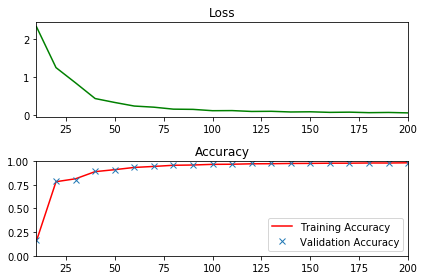

Validation accuracy at 0.9853333234786987


(10000, 28, 28, 1)

In [ ]:
def cnn_main():
    train_features, valid_features, train_labels, valid_labels, test_data, test_label = get_data()
    train_features = train_features.reshape(train_features.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    valid_features = valid_features.reshape(valid_features.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    test_data = test_data.reshape(test_data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    train_model()
    #train_features, train_labels, valid_features, valid_labels, test_data, test_label)
    #data = test_data
    return train_features, train_labels, valid_features, valid_labels, test_data, test_label
 
train_features, train_labels, valid_features, valid_labels, test_data, test_label = cnn_main() 
display(test_data.shape)

### Trained Model testing
Following cell will do the testing of model which is saved after training, against test data.
Also it will have a code to predict random image from test set.
We can also test any image outside of mnist data set


In [37]:
test_model()

INFO:tensorflow:Restoring parameters from ./cnn_digit_recognition
Nice Job! Test Accuracy is 0.9828000068664551


INFO:tensorflow:Restoring parameters from ./cnn_digit_recognition
Test Accuracy is 0.9828000068664551
INFO:tensorflow:Restoring parameters from ./cnn_digit_recognition
num: 29


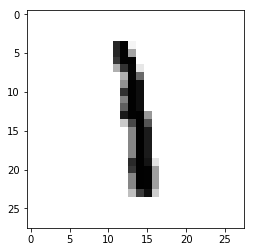

Top 3 prediction :
[[  9.92649765e+01   5.30385435e-01   7.12432787e-02]]% 
predicted value [[1 8 7]]


In [42]:
#### Call test function to test the accuracy of model against trained model
test_model()
### Call function to predict any random image from test data 
test_random_image(test_data)